In [49]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, TimeDistributed, Input, Layer
from matplotlib import pyplot as plt, pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [50]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        score = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * x
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [51]:
def visualize_trends(data):
    no_year_df = data.drop(columns=['year'], axis=1)
    pyplot.figure()
    for i in range(len(no_year_df.columns)):
        name = no_year_df.columns[i]
        if (name == 'datetime'):
            continue;
        pyplot.subplot(len(no_year_df.columns), 1, i + 1)
        pyplot.plot(no_year_df[name])
        pyplot.title(name, y=0)
        pyplot.show()


def visualize_season(data):
    years = [2007, 2008, 2009, 2010]
    pyplot.figure()
    for i in range(len(years)):
        # prepare subplot
        ax = pyplot.subplot(len(years), 1, i + 1)
        # determine the year to plot
        year = years[i]
        # get all observations for the year
        mask = data['year'].isin([year])
        result = data[mask].drop(columns=['year'], axis=1)
        # plot the active power for the year
        pyplot.plot(result['Global_active_power'])
        # add a title to the subplot
        pyplot.title(str(year), y=0, loc='left')
    plt.tight_layout()
    pyplot.show()


def consumption_distribution(data):
    # histogram plot for each variable
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    # We can set the number of bins with the *bins* keyword argument.
    axs[0].hist(data['Global_active_power'], bins=100)
    axs[1].hist(data['Global_reactive_power'], bins=100)
    pyplot.show()


def get_year_df(df, year):
    new_df = df.where(df['datetime'].dt.year == year)
    return new_df.dropna(subset=['datetime'])


def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

    return mae, mse, rmse, r2


# Function to create lagged features for RNN/LSTM input
def create_lagged_features(data, number_of_lags):
    X, y = [], []
    for i in range(number_of_lags, len(data)):
        X.append(data[i-number_of_lags:i])
        y.append(data[i, 0])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)


def plot_train_val_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()


def plot_preds_to_real_vals(y_pred, y_test):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Actual vs. Predicted Power Consumption')
    plt.ylabel('Power Consumption')
    plt.xlabel('Time')
    plt.legend()
    plt.show()


# Plot the comparison between the Linear Regression model and the RNN model.
def plot_model_comparison(model_1_metrics, model_2_metrics, model_1_name, model_2_name):
    ind = np.arange(len(model_1_metrics))
    width = 0.35

    fig, ax = plt.subplots()
    bar1 = ax.bar(ind - width / 2, model_1_metrics.values(), width, label=model_1_name)
    bar2 = ax.bar(ind + width / 2, model_2_metrics.values(), width, label=model_2_name)

    # Labeling and aesthetics
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Model Metrics')
    ax.set_xticks(ind)
    ax.set_xticklabels(model_1_metrics.keys())
    ax.legend()

    plt.show()


# for ex6 # Create sequences for LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


# Plot the comparison between the two LSTM models, RNN model and the Linear Regression model.
def plot_comparison_between_models(lr_eval, rnn_eval, lstm_no_att_eval, lstm_eval):
    # Define the labels, metrics, and bar widths
    labels = list(lr_eval.keys())
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - 3*width/2, lr_eval.values(), width, label='Linear Regression')
    ax.bar(x - width/2, rnn_eval.values(), width, label='RNN')
    ax.bar(x + width/2, lstm_no_att_eval.values(), width, label='LSTM No Attention')
    ax.bar(x + 3*width/2, lstm_eval.values(), width, label='LSTM')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Comparison of Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()


def data_augmentation(data):
    # EX8 -- Augment up to 10% of the data
    num_samples_to_augment = int(0.1 * len(data))
    indices_to_augment = random.sample(range(len(data)), num_samples_to_augment)
    augmented_data = data.copy()
    for idx in indices_to_augment:
        augmented_data.iloc[idx]['Global_active_power'] *= (1 + np.random.uniform(-0.1, 0.1))
    return augmented_data


def data_reduction(data):
    # EX 9 -- Randomly remove 10% of the data
    reduction_ratio = 0.1
    num_samples_to_remove = int(reduction_ratio * len(data))
    indices_to_remove = random.sample(range(len(data)), num_samples_to_remove)
    reduced_data = data.drop(data.index[indices_to_remove])
    return reduced_data


def data_resample_2min(data):
    # EX 10 -- Resample the data to 2-minute intervals
    data_resampled = data.resample('2T').mean()
    # Handle any NaN values that may result from resampling
    data_resampled = data_resampled.fillna(method='ffill').fillna(method='bfill')
    return data_resampled


def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)
    x = Attention()(x)
    x = Dense(25, activation='relu')(x)
    outputs = Dense(1)(x)
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

        
def plot_metrics_for_model(standard_eval, aug_eval, red_eval, resolution_eval, model_name):
    # Define the labels, metrics, and bar widths
    labels = list(standard_eval.keys())
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - 3*width/2, standard_eval.values(), width, label='Standard')
    ax.bar(x - width/2, aug_eval.values(), width, label='Augmented')
    ax.bar(x + width/2, red_eval.values(), width, label='Reduced')
    ax.bar(x + 3*width/2, resolution_eval.values(), width, label='Resolution')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(model_name + 'Model Evaluation Across Different Data Modifications')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# EX 1 - Load the Dataset

In [52]:
data = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
                      infer_datetime_format=True,
                      parse_dates={'datetime': [0, 1]})

data['year'] = data['datetime'].dt.year
data = data.set_index('datetime')

C:\Users\benre\AppData\Local\Temp\ipykernel_3632\4252497434.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
C:\Users\benre\AppData\Local\Temp\ipykernel_3632\4252497434.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,


# EX 2 - Perform Exploratory Data Analysis (EDA) of the dataset

In [53]:
data.replace('?', 'Nan', inplace=True)
# Replace all the object types into float types.
data = data.astype({'Global_active_power': 'float64', 'Global_reactive_power': 'float64', 'Voltage': 'float64',
                    'Global_intensity': 'float64', 'Sub_metering_1': 'float64', 'Sub_metering_2': 'float64'})

data.dropna(inplace=True)

Time Series Trends:


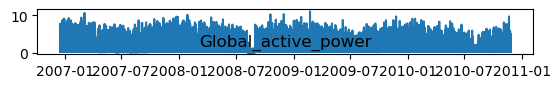

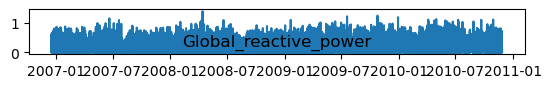

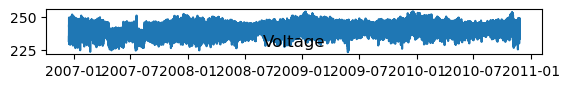

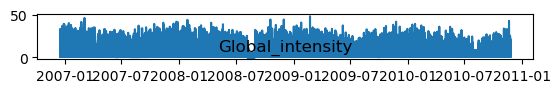

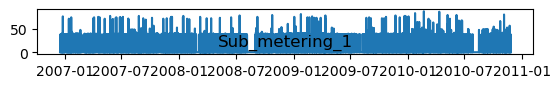

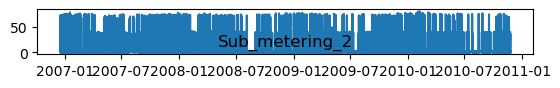

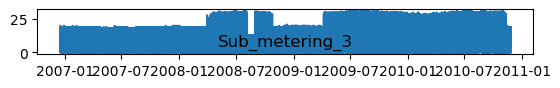


Time Series Seasonal Trends:


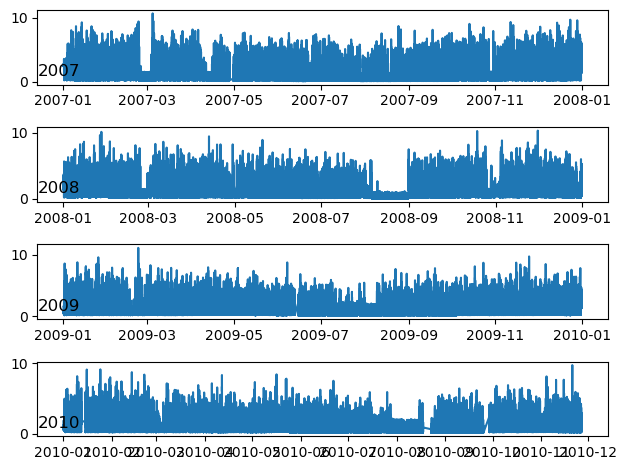


Consumption Distribution:


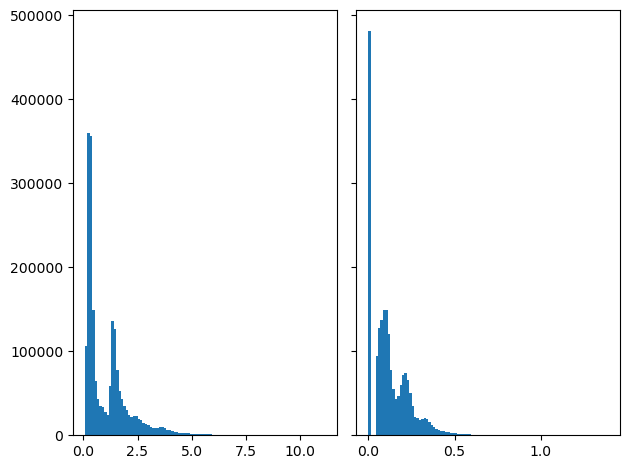

In [54]:
#Visualize time series trends
print('Time Series Trends:')
visualize_trends(data)
#Visualize time series seasonal trends
print('\nTime Series Seasonal Trends:')
visualize_season(data)
#Visualize time series consumption distribution
print('\nConsumption Distribution:')
consumption_distribution(data)

In [55]:
data = data.drop(columns=['year'], axis=1)

# EX 3 - Implement Linear Regression Model and Make Predictions

In [56]:
# Prepare lag features for the model
data['Lag_1'] = data['Global_active_power'].shift(1)  # Lag of 1 time period
data['Lag_2'] = data['Global_active_power'].shift(2)  # Lag of 2 time periods
data['Lag_3'] = data['Global_active_power'].shift(3)  # Lag of 3 time periods

# Drop NaN values created by lag features
data_prepared = data.dropna()

In [57]:
# Define the features and target variable
X = data_prepared[['Lag_1', 'Lag_2', 'Lag_3']]
y = data_prepared['Global_active_power']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
# Make predictions
y_pred = model.predict(X_test)

# EX 4 - Evaluate Linear Regression Model

In [59]:
# Evaluate and print linear regression model scores.
mae_lr, mse_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred)

Mean Absolute Error: 0.09615564310503452
Mean Squared Error: 0.06851651449291793
Root Mean Squared Error: 0.26175659398173323
R-squared: 0.9386917084684576


# EX 5 - Implement a Recurrent Neural Network (RNN)

In [60]:
rnn_df = data.drop(columns=['Lag_1', 'Lag_2', 'Lag_3'], axis=1)

scaler = MinMaxScaler()
feature_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1',
                   'Sub_metering_2', 'Sub_metering_3']
features = rnn_df[feature_columns]
scaled_features = scaler.fit_transform(features)

X_rnn, y_rnn = create_lagged_features(scaled_features, 3)

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.2, random_state=0)

In [61]:
model = tf.keras.models.Sequential([
    SimpleRNN(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=64, validation_data=(X_test_rnn, y_test_rnn), verbose=1)

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25616/25616 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 8.8676e-04 - val_loss: 5.3759e-04
Epoch 2/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 5.5174e-04 - val_loss: 5.4336e-04
Epoch 3/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 5.4167e-04 - val_loss: 5.2961e-04
Epoch 4/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 5.4607e-04 - val_loss: 5.3188e-04
Epoch 5/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 5.3959e-04 - val_loss: 5.3637e-04
Epoch 6/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 5.4399e-04 - val_loss: 5.3650e-04
Epoch 7/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 5.2862e-04 - val_loss: 5.0968e-04
Epoch 8/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 5.2235e-04 - val_loss: 5.0353e-04
Epoch 9/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 5.1582e-04 - val_loss: 4.9327e-04
Epoch 10/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 5.0782e-04 - val_loss: 4.9521e-04


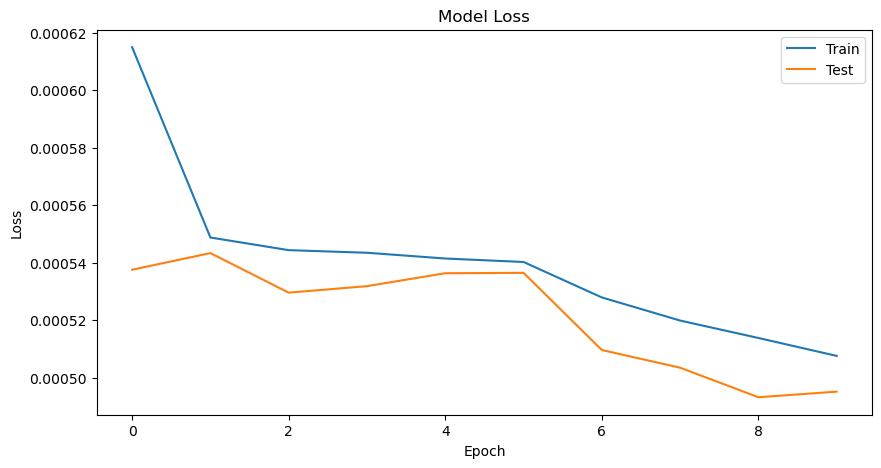

In [62]:
# Plot training & validation loss values
plot_train_val_loss(history)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 11s 860us/step


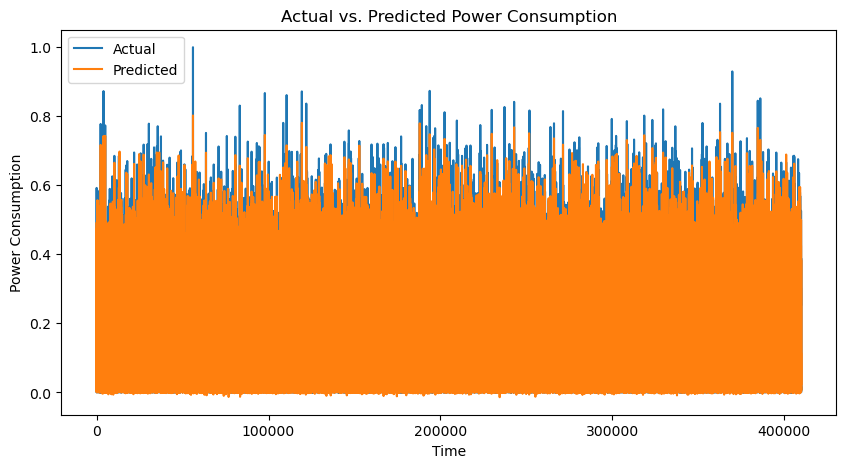

In [63]:
# Making predictions
y_pred_rnn = model.predict(X_test_rnn)

# Plot actual vs. predicted values
plot_preds_to_real_vals(y_pred_rnn, y_test_rnn)

Mean Absolute Error: 0.00871845776760813
Mean Squared Error: 0.0004952082287215715
Root Mean Squared Error: 0.022253274561771164
R-squared: 0.9459342935064727


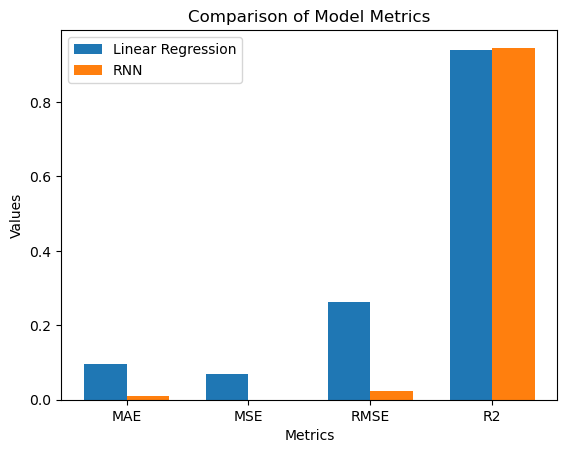

In [64]:
mae_rnn, mse_rnn, rmse_rnn, r2_rnn = evaluate_model(y_test_rnn, y_pred_rnn)

metrics_lr = {'MAE': mae_lr, 'MSE': mse_lr, 'RMSE': rmse_lr, 'R2': r2_lr}
metrics_rnn = {'MAE': mae_rnn, 'MSE': mse_rnn, 'RMSE': rmse_rnn, 'R2': r2_rnn}

plot_model_comparison(metrics_lr, metrics_rnn, 'Linear Regression', 'RNN')

We can see in the graphs that the RNN model performs much better when it comes to the MAE, MSE and RMSE loss functions. When looking at the R2 difference between the Linear Regression model and the RNN, we can see that there is not too much difference even though the Linear Regression model performed worse than the RNN model. The R2 loss function gives us a good indication that the model was well fit to the data and that the model has a good predictive power. For both models we have good performance for their respective ability but in the end the RNN model has better results than the Linear Regression.

# EX 6 - Implement a Long Short-Term Memory (LSTM) model

In [65]:
dataset = data[['Global_active_power']].dropna()

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
print(data.shape)

time_steps = 10
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape)

(2049280, 10)
(2049270, 10, 1)
(1639416, 10, 1)


In [66]:
# Design the LSTM model
model = tf.keras.models.Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25616/25616 ━━━━━━━━━━━━━━━━━━━━ 174s 7ms/step - loss: 7.4536e-04 - val_loss: 3.9419e-04
Epoch 2/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 173s 7ms/step - loss: 6.0717e-04 - val_loss: 4.0947e-04
Epoch 3/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - loss: 5.9975e-04 - val_loss: 3.9720e-04
Epoch 4/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 170s 7ms/step - loss: 5.9764e-04 - val_loss: 3.9556e-04
Epoch 5/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 167s 7ms/step - loss: 5.8172e-04 - val_loss: 3.7489e-04
Epoch 6/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 171s 7ms/step - loss: 5.5800e-04 - val_loss: 3.6825e-04
Epoch 7/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 168s 7ms/step - loss: 5.4706e-04 - val_loss: 3.6552e-04
Epoch 8/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - loss: 5.4166e-04 - val_loss: 3.6598e-04
Epoch 9/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - loss: 5.2842e-04 - val_loss: 3.6113e-04
Epoch 10/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 170s 7ms/step - loss: 5.3077e-04 - val_loss: 3.5342e-04


In [67]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step


C:\Users\benre\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


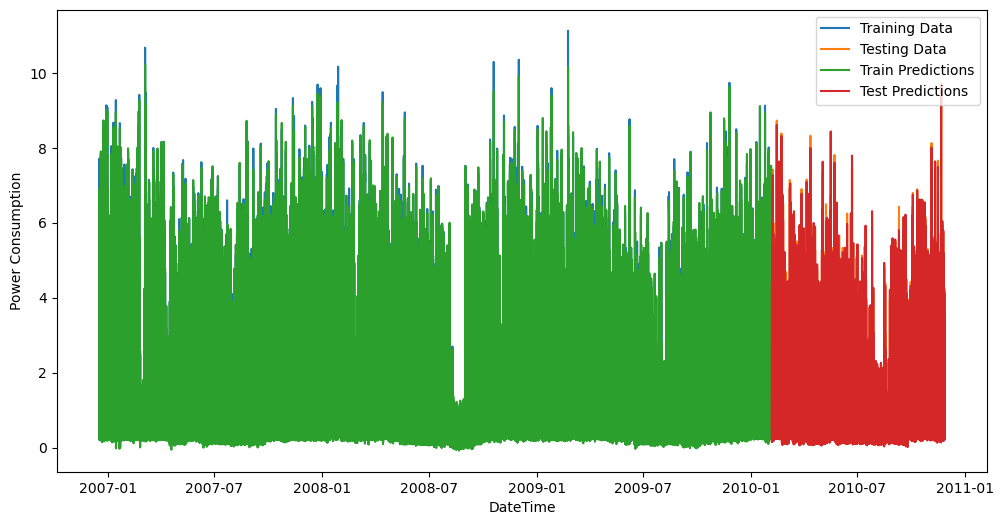

In [68]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(y_train)], y_train_inv, label='Training Data')
plt.plot(data.index[len(y_train):len(y_train)+len(y_test)], y_test_inv, label='Testing Data')
plt.plot(data.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(data.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict, label='Test Predictions')
plt.xlabel('DateTime')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

In [69]:
mae_lstm, mse_lstm, rmse_lstm, r2_lstm = evaluate_model(y_test_inv, test_predict)

Mean Absolute Error: 0.08129069923690561
Mean Squared Error: 0.043121596508137114
Root Mean Squared Error: 0.20765740176583428
R-squared: 0.9462889720452639


In [70]:
metrics_lstm_no_att_std = {'MAE': mae_lstm, 'MSE': mse_lstm, 'RMSE': rmse_lstm, 'R2': r2_lstm}

# EX 7 - Implement an LSTM model with an Attention layer 

In [71]:
model = create_model((time_steps, 1))
model.summary()

#train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_3 (Attention)              │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 196s 4ms/step - loss: 8.0566e-04 - val_loss: 4.3455e-04


In [72]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [73]:
# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

C:\Users\benre\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


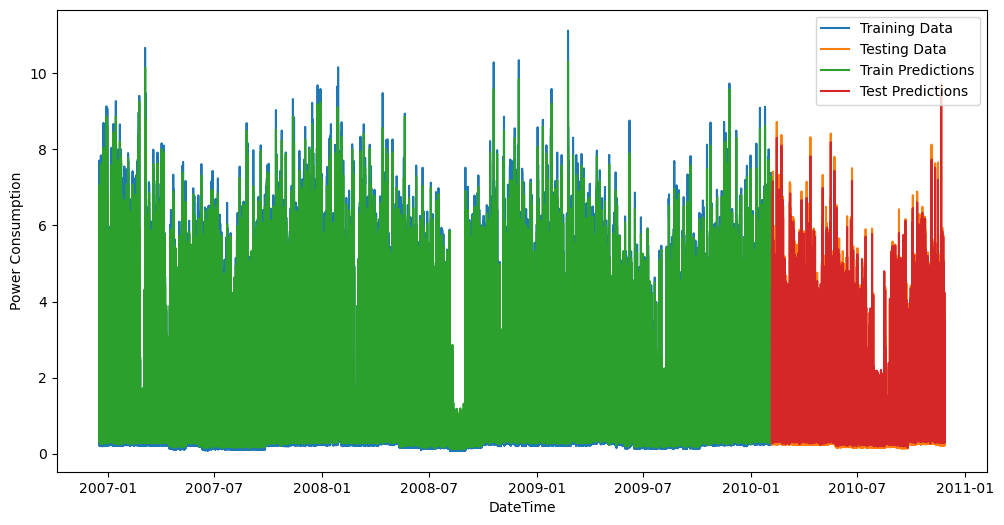

In [74]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(y_train)], y_train_inv, label='Training Data')
plt.plot(data.index[len(y_train):len(y_train)+len(y_test)], y_test_inv, label='Testing Data')
plt.plot(data.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(data.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict, label='Test Predictions')
plt.xlabel('DateTime')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

In [75]:
mae_lstm_att, mse_lstm_att, rmse_lstm_att, r2_lstm_att = evaluate_model(y_test_inv, test_predict)

Mean Absolute Error: 0.12892457328554202
Mean Squared Error: 0.05302068818806257
Root Mean Squared Error: 0.23026221615380707
R-squared: 0.9339589464200151


In [76]:
metrics_lstm_std = {'MAE': mae_lstm_att, 'MSE': mse_lstm_att, 'RMSE': rmse_lstm_att, 'R2': r2_lstm_att}

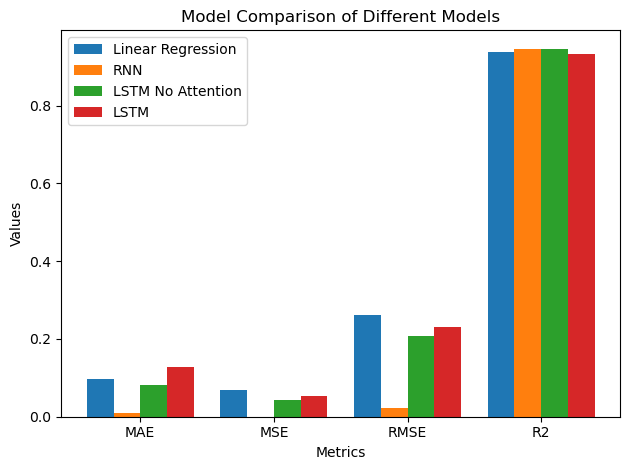

In [77]:
plot_comparison_between_models(metrics_lr, metrics_rnn, metrics_lstm_no_att_std, metrics_lstm_std)

# EX 8 - Data augmentation experiment

In [78]:
augmented_data = data_augmentation(data.drop(columns=['Lag_1', 'Lag_2', 'Lag_3'], axis=1))

In [79]:
scaler = MinMaxScaler()
features_augmented = scaler.fit_transform(augmented_data[feature_columns])

In [80]:
X_aug, y_aug = create_lagged_features(features_augmented, 3)
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y_aug, test_size=0.2, random_state=0)

In [81]:
input_shape = (X_train_aug.shape[1], X_train_aug.shape[2])
model_lstm = create_model(input_shape)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_aug = model_lstm.fit(X_train_aug, y_train_aug, epochs=10, batch_size=64, validation_data=(X_test_aug, y_test_aug))

Epoch 1/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 7.0797e-04 - val_loss: 5.1077e-04
Epoch 2/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 5.1508e-04 - val_loss: 5.1401e-04
Epoch 3/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 5.0336e-04 - val_loss: 4.8402e-04
Epoch 4/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.8919e-04 - val_loss: 4.8211e-04
Epoch 5/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.8458e-04 - val_loss: 4.6973e-04
Epoch 6/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.7850e-04 - val_loss: 4.5458e-04
Epoch 7/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.6593e-04 - val_loss: 4.4709e-04
Epoch 8/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.5774e-04 - val_loss: 4.4680e-04
Epoch 9/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.5279e-04 - val_loss: 4.6214e-04
Epoch 10/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 4.5219e-04 - val_loss: 4.3861e-04


In [82]:
y_pred_aug = model_lstm.predict(X_test_aug)
mae_aug, mse_aug, rmse_aug, r2_aug = evaluate_model(y_test_aug, y_pred_aug)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Mean Absolute Error: 0.008176013048318127
Mean Squared Error: 0.00043860783247437094
Root Mean Squared Error: 0.020942966181378676
R-squared: 0.9520819527058427


In [83]:
model = tf.keras.models.Sequential([
    SimpleRNN(50, input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]), return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_aug, y_train_aug, epochs=10, batch_size=64, validation_data=(X_test_aug, y_test_aug), verbose=1)

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25616/25616 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 7.0677e-04 - val_loss: 5.5724e-04
Epoch 2/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.5803e-04 - val_loss: 5.3906e-04
Epoch 3/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.5275e-04 - val_loss: 5.3492e-04
Epoch 4/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.5308e-04 - val_loss: 5.6416e-04
Epoch 5/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4874e-04 - val_loss: 5.4384e-04
Epoch 6/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4889e-04 - val_loss: 5.3860e-04
Epoch 7/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4774e-04 - val_loss: 5.2928e-04
Epoch 8/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.5211e-04 - val_loss: 5.3860e-04
Epoch 9/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4748e-04 - val_loss: 5.3363e-04
Epoch 10/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4279e-04 - val_loss: 5.2165e-04


In [84]:
y_pred_aug_rnn = model.predict(X_test_aug)
mae_aug_rnn, mse_aug_rnn, rmse_aug_rnn, r2_aug_rnn = evaluate_model(y_test_aug, y_pred_aug_rnn)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 11s 847us/step
Mean Absolute Error: 0.009534167178288935
Mean Squared Error: 0.0005216530057452564
Root Mean Squared Error: 0.022839724292233837
R-squared: 0.943009240716418


In [85]:
model_no_att = tf.keras.models.Sequential()
model_no_att.add(LSTM(50, return_sequences=True, input_shape=(X_train_aug.shape[1], X_train_aug.shape[2])))
model_no_att.add(LSTM(50, return_sequences=False))
model_no_att.add(Dense(25))
model_no_att.add(Dense(1))

model_no_att.compile(optimizer='adam', loss='mean_squared_error')

history = model_no_att.fit(X_train_aug, y_train_aug, batch_size=64, epochs=10, validation_data=(X_test_aug, y_test_aug)) # Use a batch size of 64 for faster processing

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25616/25616 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - loss: 6.6884e-04 - val_loss: 5.1897e-04
Epoch 2/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 5.3276e-04 - val_loss: 5.0813e-04
Epoch 3/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - loss: 5.2220e-04 - val_loss: 5.1474e-04
Epoch 4/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 5.1180e-04 - val_loss: 4.8103e-04
Epoch 5/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 4.9200e-04 - val_loss: 4.8013e-04
Epoch 6/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 4.7928e-04 - val_loss: 4.6061e-04
Epoch 7/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 4.7378e-04 - val_loss: 4.6087e-04
Epoch 8/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 4.6427e-04 - val_loss: 4.5363e-04
Epoch 9/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 4.5907e-04 - val_loss: 4.6018e-04
Epoch 10/10
25616/25616 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 4.5151e-04 - val_loss: 4.4685e-04


In [86]:
y_pred_aug_no_att = model_no_att.predict(X_test_aug)
mae_aug_no_att, mse_aug_no_att, rmse_aug_no_att, r2_aug_no_att = evaluate_model(y_test_aug, y_pred_aug_no_att)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Mean Absolute Error: 0.009268354454480387
Mean Squared Error: 0.0004468535177702336
Root Mean Squared Error: 0.02113891004215292
R-squared: 0.9511811089253045


# EX 9 - Data reduction experiment

In [87]:
reduced_data = data_reduction(data.drop(columns=['Lag_1', 'Lag_2', 'Lag_3'], axis=1))

In [88]:
scaler = MinMaxScaler()
features_reduced = scaler.fit_transform(reduced_data[feature_columns])

In [89]:
X_red, y_red = create_lagged_features(features_reduced, 3)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=0)

In [90]:
input_shape = (X_train_red.shape[1], X_train_red.shape[2])
model_lstm = create_model(input_shape)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_aug = model_lstm.fit(X_train_red, y_train_red, epochs=10, batch_size=64, validation_data=(X_test_red, y_test_red))

Epoch 1/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 7.9877e-04 - val_loss: 5.7577e-04
Epoch 2/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.8672e-04 - val_loss: 5.7775e-04
Epoch 3/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.7450e-04 - val_loss: 5.6324e-04
Epoch 4/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.5689e-04 - val_loss: 5.5902e-04
Epoch 5/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.5302e-04 - val_loss: 5.3189e-04
Epoch 6/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.3901e-04 - val_loss: 5.5537e-04
Epoch 7/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.3337e-04 - val_loss: 5.1944e-04
Epoch 8/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.2416e-04 - val_loss: 5.1722e-04
Epoch 9/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.1864e-04 - val_loss: 5.1100e-04
Epoch 10/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 5.1319e-04 - val_loss: 5.1850e-04


In [91]:
y_pred_red = model_lstm.predict(X_test_red)
mae_red, mse_red, rmse_red, r2_red = evaluate_model(y_test_red, y_pred_red)

11528/11528 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Mean Absolute Error: 0.008724119734923916
Mean Squared Error: 0.0005184960589441679
Root Mean Squared Error: 0.02277050853503645
R-squared: 0.9433197303167732


In [92]:
model = tf.keras.models.Sequential([
    SimpleRNN(50, input_shape=(X_train_red.shape[1], X_train_red.shape[2]), return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_red, y_train_red, epochs=10, batch_size=64, validation_data=(X_test_red, y_test_red), verbose=1)

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23055/23055 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 8.0766e-04 - val_loss: 6.1915e-04
Epoch 2/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 6.2998e-04 - val_loss: 6.4484e-04
Epoch 3/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 6.0881e-04 - val_loss: 6.1670e-04
Epoch 4/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 6.1453e-04 - val_loss: 6.0336e-04
Epoch 5/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 6.1252e-04 - val_loss: 6.1189e-04
Epoch 6/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 6.0679e-04 - val_loss: 5.8794e-04
Epoch 7/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 5.9518e-04 - val_loss: 5.8697e-04
Epoch 8/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 5.9572e-04 - val_loss: 5.8459e-04
Epoch 9/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 5.9544e-04 - val_loss: 5.8413e-04
Epoch 10/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 5.8173e-04 - val_loss: 5.7466e-04


In [93]:
y_pred_red_rnn = model.predict(X_test_red)
mae_red_rnn, mse_red_rnn, rmse_red_rnn, r2_red_rnn = evaluate_model(y_test_red, y_pred_red_rnn)

11528/11528 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Mean Absolute Error: 0.009057982451441383
Mean Squared Error: 0.000574660315562137
Root Mean Squared Error: 0.023972073660034857
R-squared: 0.9371800400399619


In [94]:
model_no_att = tf.keras.models.Sequential()
model_no_att.add(LSTM(50, return_sequences=True, input_shape=(X_train_red.shape[1], X_train_red.shape[2])))
model_no_att.add(LSTM(50, return_sequences=False))
model_no_att.add(Dense(25))
model_no_att.add(Dense(1))

model_no_att.compile(optimizer='adam', loss='mean_squared_error')

history = model_no_att.fit(X_train_red, y_train_red, batch_size=64, epochs=10, validation_data=(X_test_red, y_test_red)) # Use a batch size of 64 for faster processing

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23055/23055 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 7.3298e-04 - val_loss: 6.0328e-04
Epoch 2/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 6.0383e-04 - val_loss: 5.9358e-04
Epoch 3/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 5.8654e-04 - val_loss: 5.7318e-04
Epoch 4/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 5.7244e-04 - val_loss: 5.6561e-04
Epoch 5/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 5.5904e-04 - val_loss: 5.5001e-04
Epoch 6/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 5.4893e-04 - val_loss: 5.3439e-04
Epoch 7/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - loss: 5.3810e-04 - val_loss: 5.5414e-04
Epoch 8/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 5.2383e-04 - val_loss: 5.2081e-04
Epoch 9/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 5.1681e-04 - val_loss: 5.2828e-04
Epoch 10/10
23055/23055 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 5.1578e-04 - val_loss: 5.2284e-04


In [95]:
y_pred_red_no_att = model_no_att.predict(X_test_red)
mae_red_no_att, mse_red_no_att, rmse_red_no_att, r2_red_no_att = evaluate_model(y_test_red, y_pred_red_no_att)

11528/11528 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Mean Absolute Error: 0.008884118645587039
Mean Squared Error: 0.0005228442589595819
Root Mean Squared Error: 0.02286578795842343
R-squared: 0.9428443995109573


# EX 10 - Data resolution experiment

In [96]:
data_resolution = data_resample_2min(data.drop(columns=['Lag_1', 'Lag_2', 'Lag_3'], axis=1))

C:\Users\benre\AppData\Local\Temp\ipykernel_3632\3267202949.py:168: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resampled = data_resampled.fillna(method='ffill').fillna(method='bfill')


In [97]:
scaler = MinMaxScaler()
features_resolution = scaler.fit_transform(data_resolution[feature_columns])

In [98]:
X_resolution, y_resolution = create_lagged_features(features_resolution, 3)
X_train_resolution, X_test_resolution, y_train_resolution, y_test_resolution = train_test_split(X_resolution, y_resolution, test_size=0.2, random_state=0)

In [99]:
input_shape = (X_train_resolution.shape[1], X_train_resolution.shape[2])
model_lstm = create_model(input_shape)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_resolution = model_lstm.fit(X_train_resolution, y_train_resolution, epochs=10, batch_size=64, validation_data=(X_test_resolution, y_test_resolution))

Epoch 1/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0011 - val_loss: 8.7322e-04
Epoch 2/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 8.2842e-04 - val_loss: 8.0769e-04
Epoch 3/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 8.0649e-04 - val_loss: 8.2516e-04
Epoch 4/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 7.8786e-04 - val_loss: 7.7509e-04
Epoch 5/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - loss: 7.6028e-04 - val_loss: 7.6654e-04
Epoch 6/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 7.4095e-04 - val_loss: 7.6091e-04
Epoch 7/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 7.2854e-04 - val_loss: 7.3163e-04
Epoch 8/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 7.1721e-04 - val_loss: 7.2078e-04
Epoch 9/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 7.1570e-04 - val_loss: 7.0438e-04
Epoch 10/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 7.0955e-04 - val_loss: 7.3625e-04


In [100]:
y_pred_resolution = model_lstm.predict(X_test_resolution)
mae_resolution, mse_resolution, rmse_resolution, r2_resolution = evaluate_model(y_test_resolution, y_pred_resolution)

6486/6486 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Mean Absolute Error: 0.011862055562405193
Mean Squared Error: 0.0007362524542691289
Root Mean Squared Error: 0.0271339723274925
R-squared: 0.9222502257300942


In [101]:
model = tf.keras.models.Sequential([
    SimpleRNN(50, input_shape=(X_train_resolution.shape[1], X_train_resolution.shape[2]), return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_resolution, y_train_resolution, epochs=10, batch_size=64, validation_data=(X_test_resolution, y_test_resolution), verbose=1)

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12971/12971 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0011 - val_loss: 9.0506e-04
Epoch 2/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.8282e-04 - val_loss: 8.7635e-04
Epoch 3/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 8.6191e-04 - val_loss: 8.5214e-04
Epoch 4/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.4298e-04 - val_loss: 8.3470e-04
Epoch 5/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.4242e-04 - val_loss: 8.9266e-04
Epoch 6/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 8.3225e-04 - val_loss: 8.2571e-04
Epoch 7/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.3782e-04 - val_loss: 8.0508e-04
Epoch 8/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.0036e-04 - val_loss: 8.3446e-04
Epoch 9/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 7.8435e-04 - val_loss: 7.8525e-04
Epoch 10/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 7.8023e-04 - val_loss: 7.6989e-04


In [102]:
y_pred_resolution_rnn = model.predict(X_test_resolution)
mae_resolution_rnn, mse_resolution_rnn, rmse_resolution_rnn, r2_resolution_rnn = evaluate_model(y_test_resolution, y_pred_resolution_rnn)

6486/6486 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Mean Absolute Error: 0.011992463388381834
Mean Squared Error: 0.0007698894504960251
Root Mean Squared Error: 0.027746881815728864
R-squared: 0.9186980897085512


In [103]:
model_no_att = tf.keras.models.Sequential()
model_no_att.add(LSTM(50, return_sequences=True, input_shape=(X_train_resolution.shape[1], X_train_resolution.shape[2])))
model_no_att.add(LSTM(50, return_sequences=False))
model_no_att.add(Dense(25))
model_no_att.add(Dense(1))

model_no_att.compile(optimizer='adam', loss='mean_squared_error')

history = model_no_att.fit(X_train_resolution, y_train_resolution, batch_size=64, epochs=10, validation_data=(X_test_resolution, y_test_resolution)) # Use a batch size of 64 for faster processing

Epoch 1/10


C:\Users\benre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12971/12971 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.0011 - val_loss: 9.1310e-04
Epoch 2/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 8.3524e-04 - val_loss: 8.9814e-04
Epoch 3/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 8.2276e-04 - val_loss: 7.9829e-04
Epoch 4/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 7.8955e-04 - val_loss: 7.8951e-04
Epoch 5/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 7.6994e-04 - val_loss: 7.5873e-04
Epoch 6/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 7.5540e-04 - val_loss: 7.5189e-04
Epoch 7/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 7.3020e-04 - val_loss: 7.2578e-04
Epoch 8/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 7.2114e-04 - val_loss: 7.1084e-04
Epoch 9/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 7.1618e-04 - val_loss: 7.1830e-04
Epoch 10/10
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 7.0022e-04 - val_loss: 7.1107e-04


In [104]:
y_pred_resolution_no_att = model_lstm.predict(X_test_resolution)
mae_resolution_no_att, mse_resolution_no_att, rmse_resolution_no_att, r2_resolution_no_att = evaluate_model(y_test_resolution, y_pred_resolution_no_att)

6486/6486 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Mean Absolute Error: 0.011862055562405193
Mean Squared Error: 0.0007362524542691289
Root Mean Squared Error: 0.0271339723274925
R-squared: 0.9222502257300942


In [105]:
metrics_rnn_aug = {'MAE': mae_aug_rnn, 'MSE': mse_aug_rnn, 'RMSE': rmse_aug_rnn, 'R2': r2_aug_rnn}
metrics_rnn_red = {'MAE': mae_red_rnn, 'MSE': mse_red_rnn, 'RMSE': rmse_red_rnn, 'R2': r2_red_rnn}
metrics_rnn_resolution = {'MAE': mae_resolution_rnn, 'MSE': mse_resolution_rnn, 'RMSE': rmse_resolution_rnn, 'R2': r2_resolution_rnn}

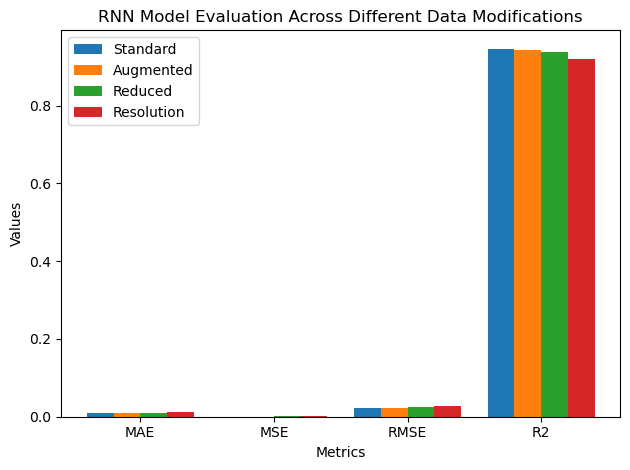

In [106]:
plot_metrics_for_model(metrics_rnn, metrics_rnn_aug, metrics_rnn_red, metrics_rnn_resolution, 'RNN ')

From the detailed breakdown of the evaluation metrics, it's clear that changing the data slightly affects the model's performance, but not too much. The slightly higher MAE, MSE, and RMSE values mean that these changes make the data a bit more complex for the model to handle. However, the fairly steady R2 scores across all data changes show that the model still explains the data's variation well. This analysis gives us useful information about the balance between data modification and model performance, emphasizing the importance of selecting the right data preprocessing methods to get the best results from the model.

In [107]:
metrics_lstm_aug = {'MAE': mae_aug, 'MSE': mse_aug, 'RMSE': rmse_aug, 'R2': r2_aug}
metrics_lstm_red = {'MAE': mae_red, 'MSE': mse_red, 'RMSE': rmse_red, 'R2': r2_red}
metrics_lstm_resolution = {'MAE': mae_resolution, 'MSE': mse_resolution, 'RMSE': rmse_resolution, 'R2': r2_resolution}

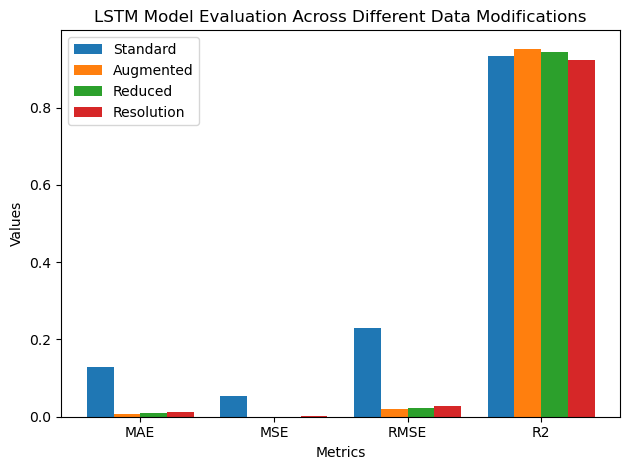

In [108]:
plot_metrics_for_model(metrics_lstm_std, metrics_lstm_aug, metrics_lstm_red, metrics_lstm_resolution, 'LSTM ')

We can see from the comparison on the metrics of MAE, MSE, RMSE and R2 for the LSTM model using different types of modifications on the dataset that the standard dataset yields the worst results according to the MAE, MSE and RMSE metrics while it is pretty consistent with the rest on the R2 metric. The best results were given when using the reduced dataset which might seem a bit weird as we were removing data. We would expect that removing data will affect the model's learning in a bad way as we are removing data so the model is less fit (in comparison to having more data to learn from). As we can see the resolution model also yields good performance in all metrics but the reduced dataset is still a bit better according to these metrics.

In [109]:
metrics_lstm_no_att_aug = {'MAE': mae_aug_no_att, 'MSE': mse_aug_no_att, 'RMSE': rmse_aug_no_att, 'R2': r2_aug_no_att}
metrics_lstm_no_att_red = {'MAE': mae_red_no_att, 'MSE': mse_red_no_att, 'RMSE': rmse_red_no_att, 'R2': r2_red_no_att}
metrics_lstm_no_att_resolution = {'MAE': mae_resolution_no_att, 'MSE': mse_resolution_no_att, 'RMSE': rmse_resolution_no_att, 'R2': r2_resolution_no_att}

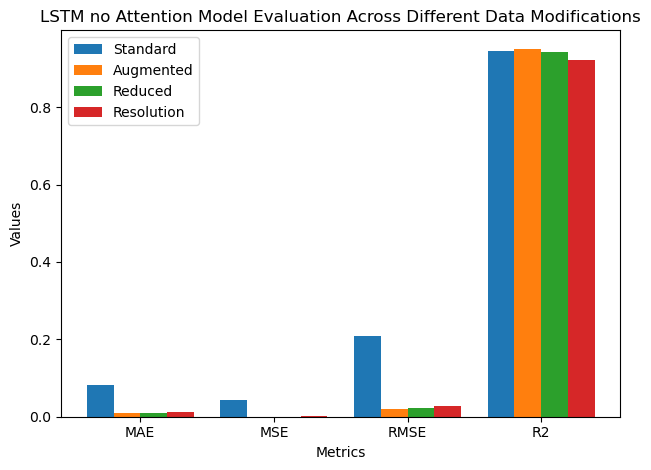

In [110]:
plot_metrics_for_model(metrics_lstm_no_att_std, metrics_lstm_no_att_aug, metrics_lstm_no_att_red, metrics_lstm_no_att_resolution, 'LSTM no Attention ')

As we can see from the comparison of the metrics resulted from the LSTM model with no Attention layer on different data modifications, the "augmented" dataset yielded the best results through all metrics. We can also see that the reduced dataset had good performance but the augmented one was still better. Overall we can see that performing data modifications yielded better results for all modfied datasets than the standard dataset without any change (besides basic cleaning before starting to work with it).

# EX 11 - Conclusion and insights

From our experiments, we observed how different data modifications influenced the performance of our models, including Linear Regression, RNN, LSTM, and LSTM with Attention. The LSTM model, particularly without the Attention layer, showed the best results with the augmented dataset, achieving lower error rates in MAE, MSE, and RMSE. Interestingly, the reduced dataset, where up to 10% of the data was removed, also performed well, sometimes surpassing the augmented dataset. This suggests that data quality can be more critical than quantity. The resolution-modified dataset, with a 50% reduction in time resolution, maintained good performance but was slightly outperformed by the reduced dataset. Throughout all experiments, the R2 metric remained consistent, indicating stable explanatory power across models and modifications.

From the evaluation metrics we can see that modifying the data has an impact on the model performance. The LSTM model without the Attention layer performed best with the augmented dataset, showing lower MAE, MSE, and RMSE values, indicating better accuracy. The reduced dataset also performed well, sometimes better than the augmented dataset, showing that sometimes data quality is more important than quantity. The resolution-modified dataset maintained good performance, though slightly outperformed by the reduced dataset. Overall, these experiments show that it is important to be careful with data preprocessing and modification when trying optimize model performance, with the LSTM model showing strong adaptability and predictive power across different data conditions.